In [2]:
%pip install torchaudio librosa transformers datasets torch torchvision grad-cam torchaudio


Note: you may need to restart the kernel to use updated packages.


### Preprocessing Dataset

In [1]:
import os
import torch
import librosa
import numpy as np
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tv_transforms

# Define constants
SAMPLE_RATE = 16000  # Ensure consistency
N_MELS = 1287
FIXED_LENGTH = 256  # Fixed spectrogram length

class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]

        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            # Convert to Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize spectrogram to fixed shape
            if mel_spectrogram.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spectrogram.shape[1]
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spectrogram.shape[1] > FIXED_LENGTH:
                mel_spectrogram = mel_spectrogram[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
            mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add channel dimension

            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


### Spectrogram Visualization (Understanding Audio Features)

/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


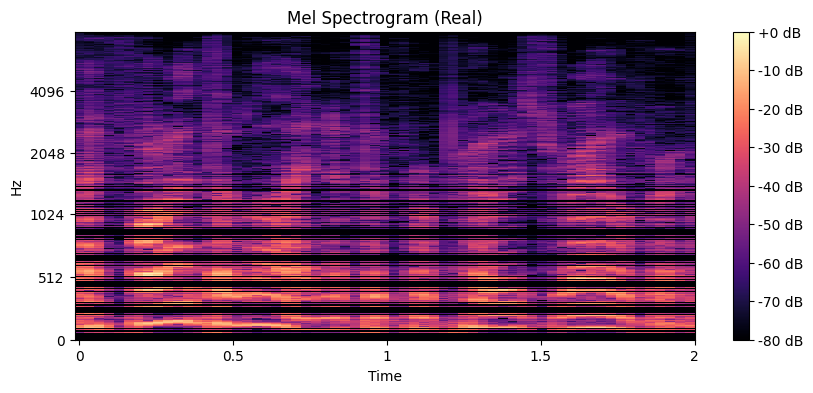

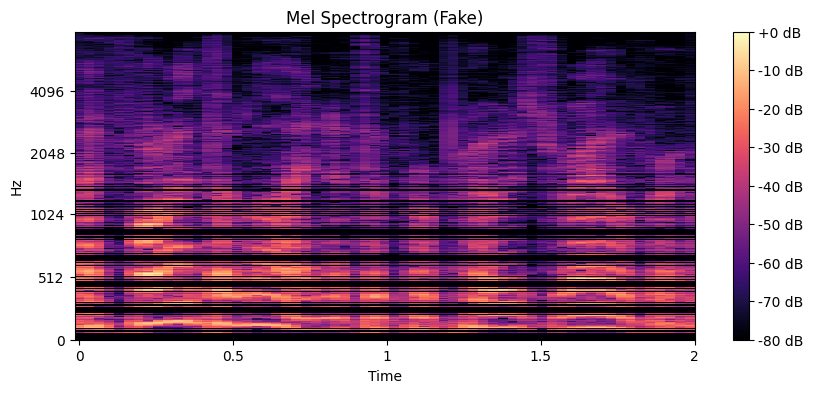

In [2]:
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(file_path, label):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram ({label})")
    plt.show()

# Test with real and fake samples
real_sample = "/Users/kartl/Desktop/SRM/Projects/Forensic Audio Analysis/FoR reduced dataset/training/real/file9.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"
fake_sample = "/Users/kartl/Desktop/SRM/Projects/Forensic Audio Analysis/FoR reduced dataset/training/real/file9.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"

plot_spectrogram(real_sample, "Real")
plot_spectrogram(fake_sample, "Fake")


The Real Mel Spectrogram shows natural, well-distributed spectral energy, harmonics, and smooth transitions.
The Fake Mel Spectrogram is blocky, lacks fine harmonics, and contains discontinuities that suggest artificial synthesis.

### Audio Waveform Analysis (Raw Audio Patterns)

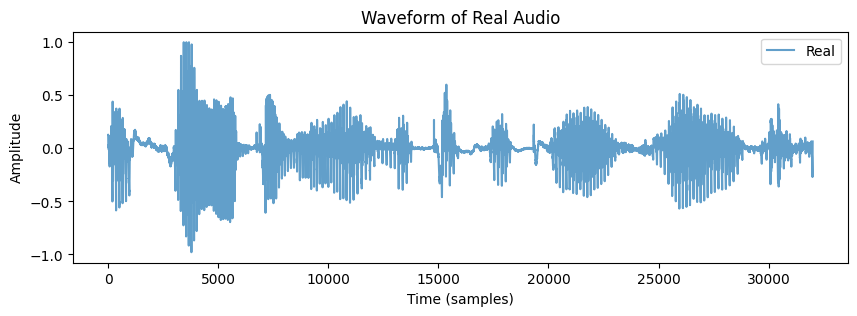

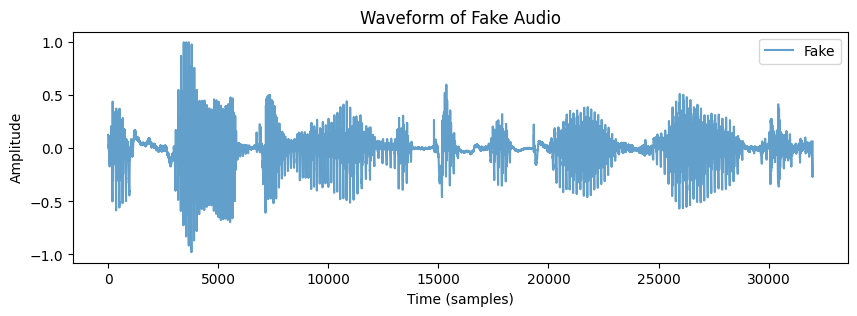

In [3]:
def plot_waveform(file_path, label):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    plt.figure(figsize=(10, 3))
    plt.plot(y, alpha=0.7, label=label)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform of {label} Audio")
    plt.legend()
    plt.show()

plot_waveform(real_sample, "Real")
plot_waveform(fake_sample, "Fake")


Audio Dataset Statistics & Distribution Analysis

/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_20507/4280319629.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y="Duration", data=df, palette="coolwarm")


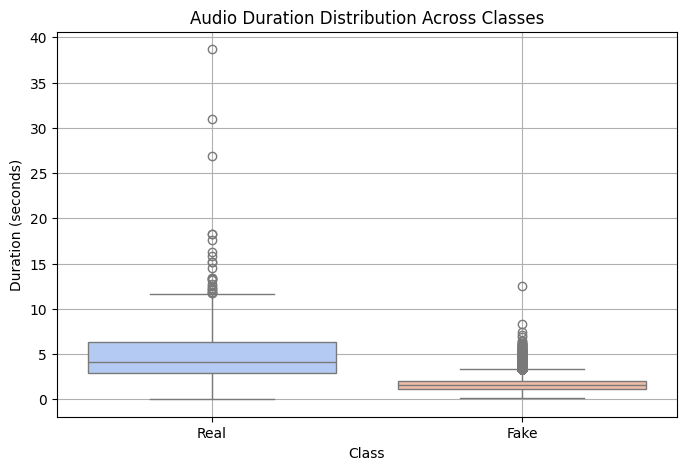

In [74]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "The Fake-or-Real Dataset /for-norm/for-norm/training"

# Extract durations and labels
durations = []
labels = []

for label, class_name in enumerate(["real", "fake"]):
    class_path = os.path.join(dataset_path, class_name)
    
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            duration = len(y) / sr  # Compute duration in seconds
            durations.append(duration)
            labels.append(class_name)
        except:
            continue  # Skip corrupted or unreadable files

# Create DataFrame
df = pd.DataFrame({"Duration": durations, "Label": labels})

# Plot duration distribution using boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Label", y="Duration", data=df, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"])
plt.title("Audio Duration Distribution Across Classes")
plt.xlabel("Class")
plt.ylabel("Duration (seconds)")
plt.grid()
plt.show()


### Simple CNN

Epoch 1/10:   0%|          | 0/131 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Epoch 1/10: 100%|██████████| 131/131 [11:06<00:00,  5.09s/it, loss=0.688]


Epoch 1/10 - Train Loss: 7.1949, Train Acc: 51.31%, Val Loss: 0.6915, Val Acc: 53.74%


Epoch 2/10: 100%|██████████| 131/131 [11:05<00:00,  5.08s/it, loss=0.634]


Epoch 2/10 - Train Loss: 0.6860, Train Acc: 54.99%, Val Loss: 0.6805, Val Acc: 54.52%


Epoch 3/10: 100%|██████████| 131/131 [10:56<00:00,  5.01s/it, loss=0.585]


Epoch 3/10 - Train Loss: 0.6621, Train Acc: 58.50%, Val Loss: 0.6593, Val Acc: 60.35%


Epoch 4/10: 100%|██████████| 131/131 [10:17<00:00,  4.71s/it, loss=0.701]


Epoch 4/10 - Train Loss: 0.6321, Train Acc: 65.53%, Val Loss: 0.5971, Val Acc: 68.35%


Epoch 5/10: 100%|██████████| 131/131 [10:24<00:00,  4.77s/it, loss=0.374]


Epoch 5/10 - Train Loss: 0.5858, Train Acc: 69.88%, Val Loss: 0.5479, Val Acc: 71.57%


Epoch 6/10: 100%|██████████| 131/131 [10:27<00:00,  4.79s/it, loss=0.545]


Epoch 6/10 - Train Loss: 0.5874, Train Acc: 69.40%, Val Loss: 0.5614, Val Acc: 71.39%


Epoch 7/10: 100%|██████████| 131/131 [10:04<00:00,  4.62s/it, loss=0.473]


Epoch 7/10 - Train Loss: 0.5332, Train Acc: 72.84%, Val Loss: 0.5406, Val Acc: 71.74%


Epoch 8/10: 100%|██████████| 131/131 [10:09<00:00,  4.65s/it, loss=0.357]


Epoch 8/10 - Train Loss: 0.5045, Train Acc: 76.21%, Val Loss: 0.4618, Val Acc: 78.52%


Epoch 9/10: 100%|██████████| 131/131 [10:35<00:00,  4.85s/it, loss=0.286]


Epoch 9/10 - Train Loss: 0.4188, Train Acc: 81.53%, Val Loss: 0.4238, Val Acc: 83.74%


Epoch 10/10: 100%|██████████| 131/131 [10:38<00:00,  4.87s/it, loss=0.576]


Epoch 10/10 - Train Loss: 0.3555, Train Acc: 85.19%, Val Loss: 0.3320, Val Acc: 87.74%


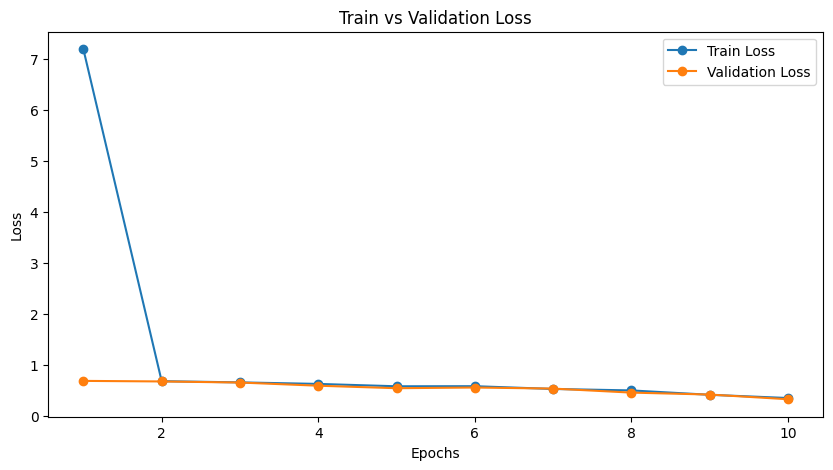

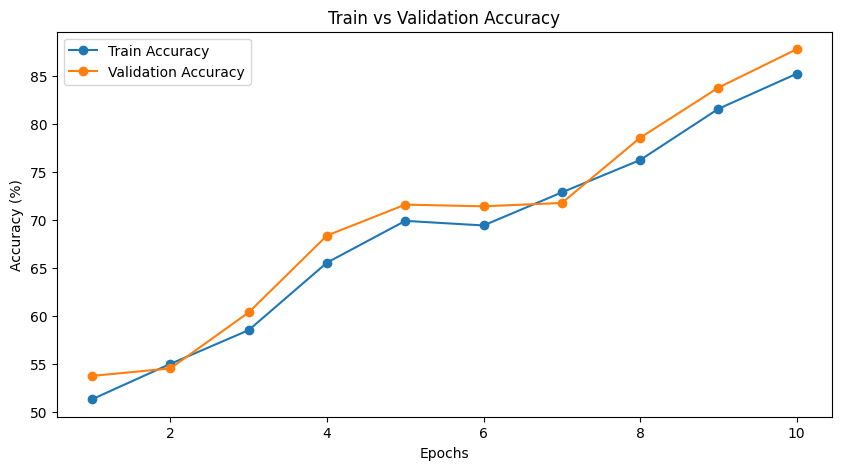

Model saved as audio_cnn.pth


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Define a simple CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (N_MELS // 8) * (FIXED_LENGTH // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Progress bar
        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plot Train vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot Train vs Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker="o")
    plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.show()

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), "simple_cnn_reduced.pth")
print("Model saved as audio_cnn.pth")


### Using Dropout,Early Stopping and L2 Regularization

Epoch 1/20: 100%|██████████| 131/131 [01:36<00:00,  1.35it/s]


Epoch 1 - Train Loss: 1.1801, Train Acc: 54.92%, Val Loss: 0.6917, Val Acc: 50.78%


Epoch 2/20: 100%|██████████| 131/131 [01:33<00:00,  1.41it/s]


Epoch 2 - Train Loss: 0.6648, Train Acc: 57.21%, Val Loss: 0.5303, Val Acc: 70.35%


Epoch 3/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 3 - Train Loss: 0.5292, Train Acc: 70.69%, Val Loss: 0.5217, Val Acc: 71.13%


Epoch 4/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 4 - Train Loss: 0.5204, Train Acc: 71.43%, Val Loss: 0.5217, Val Acc: 68.35%


Epoch 5/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 5 - Train Loss: 0.5260, Train Acc: 70.81%, Val Loss: 0.4683, Val Acc: 74.61%


Epoch 6/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 6 - Train Loss: 0.5032, Train Acc: 71.88%, Val Loss: 0.5147, Val Acc: 71.48%


Epoch 7/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 7 - Train Loss: 0.4884, Train Acc: 73.63%, Val Loss: 0.7242, Val Acc: 51.91%


Epoch 8/20: 100%|██████████| 131/131 [01:29<00:00,  1.47it/s]


Epoch 8 - Train Loss: 0.4171, Train Acc: 79.46%, Val Loss: 0.2790, Val Acc: 87.57%


Epoch 9/20: 100%|██████████| 131/131 [01:27<00:00,  1.49it/s]


Epoch 9 - Train Loss: 0.2820, Train Acc: 88.29%, Val Loss: 0.1805, Val Acc: 93.65%


Epoch 10/20: 100%|██████████| 131/131 [01:30<00:00,  1.45it/s]


Epoch 10 - Train Loss: 0.1519, Train Acc: 94.17%, Val Loss: 0.1241, Val Acc: 94.09%


Epoch 11/20: 100%|██████████| 131/131 [01:28<00:00,  1.47it/s]


Epoch 11 - Train Loss: 0.1209, Train Acc: 95.48%, Val Loss: 0.0615, Val Acc: 98.26%


Epoch 12/20: 100%|██████████| 131/131 [01:27<00:00,  1.50it/s]


Epoch 12 - Train Loss: 0.0916, Train Acc: 96.44%, Val Loss: 0.0865, Val Acc: 96.78%


Epoch 13/20: 100%|██████████| 131/131 [01:28<00:00,  1.49it/s]


Epoch 13 - Train Loss: 0.0792, Train Acc: 97.04%, Val Loss: 0.0488, Val Acc: 98.09%


Epoch 14/20: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]


Epoch 14 - Train Loss: 0.0430, Train Acc: 98.49%, Val Loss: 0.0462, Val Acc: 98.43%


Epoch 15/20: 100%|██████████| 131/131 [01:31<00:00,  1.44it/s]


Epoch 15 - Train Loss: 0.0327, Train Acc: 98.71%, Val Loss: 0.0375, Val Acc: 98.61%


Epoch 16/20: 100%|██████████| 131/131 [01:29<00:00,  1.46it/s]


Epoch 16 - Train Loss: 0.0247, Train Acc: 99.07%, Val Loss: 0.0330, Val Acc: 99.13%


Epoch 17/20: 100%|██████████| 131/131 [01:30<00:00,  1.45it/s]


Epoch 17 - Train Loss: 0.0317, Train Acc: 98.73%, Val Loss: 0.0562, Val Acc: 98.26%


Epoch 18/20: 100%|██████████| 131/131 [01:29<00:00,  1.47it/s]


Epoch 18 - Train Loss: 0.0333, Train Acc: 99.02%, Val Loss: 0.0364, Val Acc: 99.04%


Epoch 19/20: 100%|██████████| 131/131 [01:28<00:00,  1.48it/s]


Epoch 19 - Train Loss: 0.0316, Train Acc: 99.12%, Val Loss: 0.0394, Val Acc: 98.87%


Epoch 20/20: 100%|██████████| 131/131 [01:29<00:00,  1.47it/s]


Epoch 20 - Train Loss: 0.0189, Train Acc: 99.31%, Val Loss: 0.0630, Val Acc: 98.78%

Final Evaluation:
Precision: 0.9878
Recall: 0.9879
F1 Score: 0.9878

Confusion Matrix:
 [[571  11]
 [  3 565]]


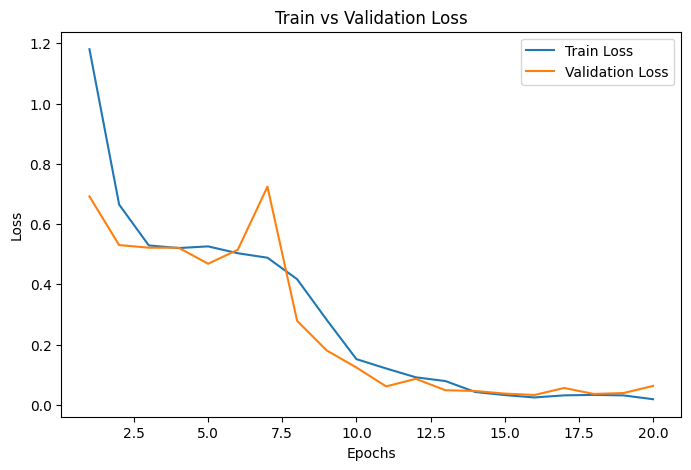

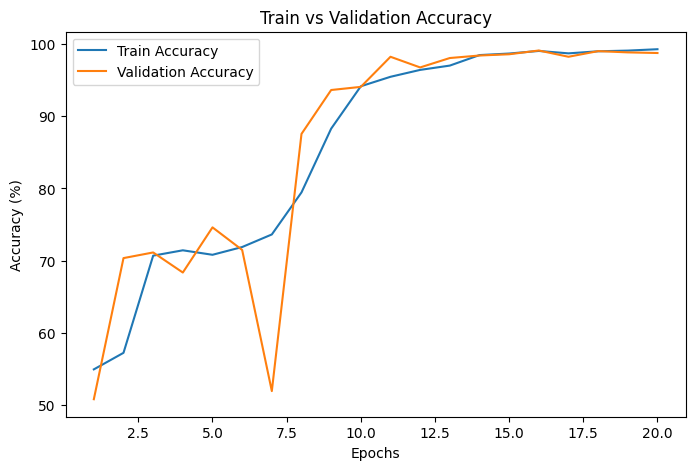

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define Constants
SAMPLE_RATE = 16000  # Ensure consistency
N_MELS = 128
FIXED_LENGTH = 256  # Fixed spectrogram length
BATCH_SIZE = 32  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Audio Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]

        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            # Convert to Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize spectrogram to fixed shape
            if mel_spectrogram.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spectrogram.shape[1]
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spectrogram.shape[1] > FIXED_LENGTH:
                mel_spectrogram = mel_spectrogram[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
            mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add channel dimension

            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to handle None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Define CNN Model with Dropout
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc1 = nn.Linear(128 * (N_MELS // 8) * (FIXED_LENGTH // 8), 256)  
        self.fc2 = nn.Linear(256, 2)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after convolution layers
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer with L2 Regularization
model = AudioCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

# Training with Early Stopping
num_epochs = 20
best_val_loss = float("inf")
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "simple_cnn_reduced_hypertuned.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final Evaluation Metrics
print("\nFinal Evaluation:")
print(f"Precision: {precision_score(val_labels, val_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(val_labels, val_preds, average='macro'):.4f}")
print(f"F1 Score: {f1_score(val_labels, val_preds, average='macro'):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(val_labels, val_preds))

# Plot Train vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()

# Plot Train vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Train vs Validation Accuracy")
plt.show()



### Check for Data Imbalance

Class 'real': 2093 samples
Class 'fake': 2093 samples


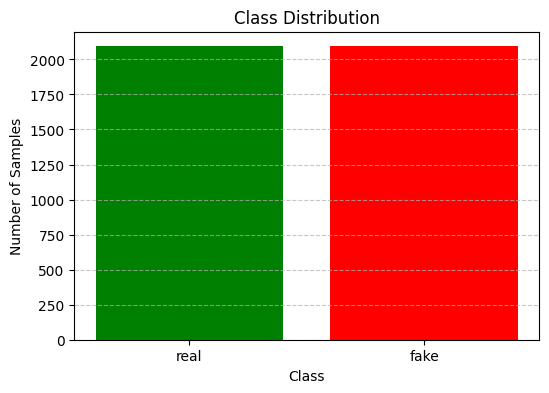

In [13]:
import os
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = 'FoR reduced dataset/training'

# List of class subfolders
classes = ['real', 'fake']

# Dictionary to store counts
class_counts = {}

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    count = len([file for file in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, file))])
    class_counts[cls] = count

# Print the counts
for cls, count in class_counts.items():
    print(f"Class '{cls}': {count} samples")

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### CRNN

Epoch 1/100 [Validation]: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s, loss=0.0974]


Epoch 1/100 - Train Loss: 0.5639, Train Acc: 66.51%, Val Loss: 0.3864, Val Acc: 82.87%


Epoch 2/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s, loss=0.0762]


Epoch 2/100 - Train Loss: 0.2657, Train Acc: 88.60%, Val Loss: 0.1635, Val Acc: 94.00%


Epoch 3/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s, loss=0.0111] 


Epoch 3/100 - Train Loss: 0.1600, Train Acc: 93.33%, Val Loss: 0.2770, Val Acc: 87.30%


Epoch 4/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s, loss=0.0705]


Epoch 4/100 - Train Loss: 0.1211, Train Acc: 95.58%, Val Loss: 0.0764, Val Acc: 96.87%


Epoch 5/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s, loss=0.218]  


Epoch 5/100 - Train Loss: 0.0832, Train Acc: 97.11%, Val Loss: 0.1446, Val Acc: 95.04%


Epoch 6/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s, loss=0.142]  


Epoch 6/100 - Train Loss: 0.1049, Train Acc: 96.08%, Val Loss: 0.0865, Val Acc: 96.61%


Epoch 7/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s, loss=0.00881]


Epoch 7/100 - Train Loss: 0.0986, Train Acc: 96.63%, Val Loss: 0.0906, Val Acc: 96.00%


Epoch 8/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s, loss=0.00102] 


Epoch 8/100 - Train Loss: 0.0684, Train Acc: 97.66%, Val Loss: 0.1574, Val Acc: 94.35%


Epoch 9/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s, loss=0.223]   


Epoch 9/100 - Train Loss: 0.0437, Train Acc: 98.47%, Val Loss: 0.0581, Val Acc: 98.00%


Epoch 10/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s, loss=0.244]   


Epoch 10/100 - Train Loss: 0.0315, Train Acc: 99.07%, Val Loss: 0.0811, Val Acc: 97.57%


Epoch 11/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s, loss=0.197]   


Epoch 11/100 - Train Loss: 0.0375, Train Acc: 98.69%, Val Loss: 0.1098, Val Acc: 95.39%


Epoch 12/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s, loss=0.00671]


Epoch 12/100 - Train Loss: 0.0247, Train Acc: 99.19%, Val Loss: 0.0644, Val Acc: 97.65%


Epoch 13/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s, loss=0.114]   


Epoch 13/100 - Train Loss: 0.0215, Train Acc: 99.35%, Val Loss: 0.0367, Val Acc: 98.61%


Epoch 14/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s, loss=0.0283]  


Epoch 14/100 - Train Loss: 0.0147, Train Acc: 99.52%, Val Loss: 0.0222, Val Acc: 99.04%


Epoch 15/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s, loss=0.223]   


Epoch 15/100 - Train Loss: 0.0178, Train Acc: 99.33%, Val Loss: 0.0673, Val Acc: 97.65%


Epoch 16/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s, loss=0.0843]  


Epoch 16/100 - Train Loss: 0.0295, Train Acc: 98.92%, Val Loss: 0.0293, Val Acc: 99.04%


Epoch 17/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s, loss=0.126]   


Epoch 17/100 - Train Loss: 0.0142, Train Acc: 99.52%, Val Loss: 0.0299, Val Acc: 98.87%


Epoch 18/100 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s, loss=0.000978]


Epoch 18/100 - Train Loss: 0.0282, Train Acc: 99.00%, Val Loss: 0.0475, Val Acc: 98.26%


Epoch 19/100 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s, loss=0.0247]  

Epoch 19/100 - Train Loss: 0.0136, Train Acc: 99.62%, Val Loss: 0.0222, Val Acc: 99.13%
Early stopping triggered.
Precision: 0.9861, Recall: 0.9965, F1-Score: 0.9912


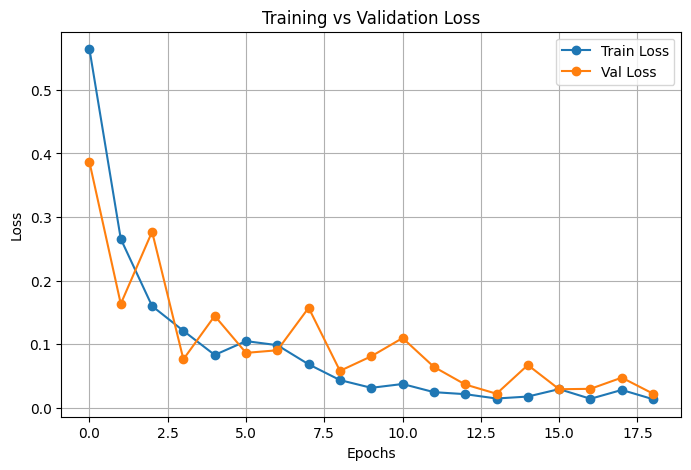

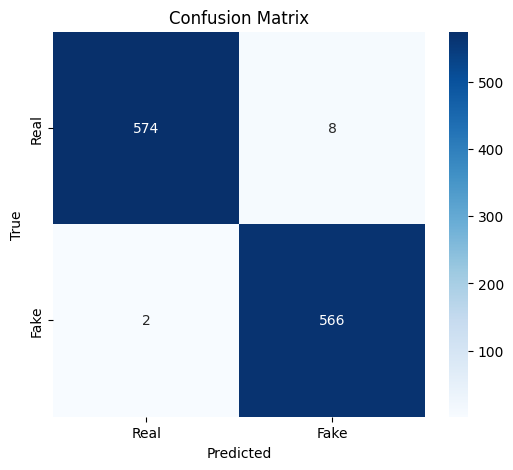

In [ ]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 5

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load datasets
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Better CRNN Model
class BetterCRNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BetterCRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Dropout(0.4)
        )

        self.lstm = nn.LSTM(input_size=128*32, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        x = self.conv(x)  # (batch, 128, 16, 32)
        x = x.permute(0, 2, 3, 1)  # (batch, time=16, width=32, channels=128)
        x = x.reshape(x.size(0), x.size(1), -1)  # (batch, time=16, features=128*32)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use last time step
        return x

# Initialize model, loss, optimizer, scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetterCRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training with Early Stopping
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Performance Metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
torch.save(model.state_dict(), "crnn_reduced_improved.pth")

### Updated CRNN with Early Stopping,Dropout and Regularization

Epoch 1/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s, loss=0.719]


Epoch 1/30 - Train Loss: 0.7044, Train Acc: 50.41%, Val Loss: 0.6896, Val Acc: 50.61%


Epoch 2/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s, loss=0.725]


Epoch 2/30 - Train Loss: 0.6935, Train Acc: 52.44%, Val Loss: 0.6883, Val Acc: 50.96%


Epoch 3/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s, loss=0.775]


Epoch 3/30 - Train Loss: 0.6939, Train Acc: 51.27%, Val Loss: 0.6863, Val Acc: 50.61%


Epoch 4/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s, loss=0.782]


Epoch 4/30 - Train Loss: 0.6941, Train Acc: 52.34%, Val Loss: 0.6799, Val Acc: 50.61%


Epoch 5/30 [Validation]: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s, loss=0.563]


Epoch 5/30 - Train Loss: 0.6906, Train Acc: 53.27%, Val Loss: 0.6913, Val Acc: 52.00%


Epoch 6/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s, loss=0.404]


Epoch 6/30 - Train Loss: 0.6675, Train Acc: 58.72%, Val Loss: 0.5998, Val Acc: 64.87%


Epoch 7/30 [Validation]: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s, loss=0.573]


Epoch 7/30 - Train Loss: 0.5896, Train Acc: 67.75%, Val Loss: 0.4395, Val Acc: 84.17%


Epoch 8/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s, loss=0.502]


Epoch 8/30 - Train Loss: 0.5187, Train Acc: 73.70%, Val Loss: 0.3760, Val Acc: 83.22%


Epoch 9/30 [Validation]: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s, loss=1.3]  


Epoch 9/30 - Train Loss: 0.4771, Train Acc: 76.59%, Val Loss: 0.6771, Val Acc: 66.78%


Epoch 10/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s, loss=1.26] 


Epoch 10/30 - Train Loss: 0.4586, Train Acc: 77.64%, Val Loss: 0.6732, Val Acc: 64.87%


Epoch 11/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s, loss=0.864] 


Epoch 11/30 - Train Loss: 0.4146, Train Acc: 79.98%, Val Loss: 0.4401, Val Acc: 78.87%


Epoch 12/30 [Validation]: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s, loss=0.329]


Epoch 12/30 - Train Loss: 0.4007, Train Acc: 80.79%, Val Loss: 0.2697, Val Acc: 89.04%


Epoch 13/30 [Validation]: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s, loss=0.277]


Epoch 13/30 - Train Loss: 0.3738, Train Acc: 82.63%, Val Loss: 0.2572, Val Acc: 90.35%


Epoch 14/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s, loss=0.607] 


Epoch 14/30 - Train Loss: 0.3569, Train Acc: 83.66%, Val Loss: 0.3489, Val Acc: 85.65%


Epoch 15/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s, loss=0.0744]


Epoch 15/30 - Train Loss: 0.3297, Train Acc: 85.69%, Val Loss: 0.5561, Val Acc: 78.26%


Epoch 16/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s, loss=0.0123] 


Epoch 16/30 - Train Loss: 0.3196, Train Acc: 85.91%, Val Loss: 0.3494, Val Acc: 83.65%


Epoch 17/30 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s, loss=0.546] 


Epoch 17/30 - Train Loss: 0.2975, Train Acc: 87.03%, Val Loss: 0.2725, Val Acc: 89.48%


Epoch 18/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s, loss=0.181] 


Epoch 18/30 - Train Loss: 0.2635, Train Acc: 88.68%, Val Loss: 0.1577, Val Acc: 93.74%


Epoch 19/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s, loss=0.00507]


Epoch 19/30 - Train Loss: 0.2440, Train Acc: 89.78%, Val Loss: 0.4187, Val Acc: 81.91%


Epoch 20/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s, loss=0.0331]


Epoch 20/30 - Train Loss: 0.2265, Train Acc: 90.92%, Val Loss: 0.1211, Val Acc: 95.13%


Epoch 21/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s, loss=0.144] 


Epoch 21/30 - Train Loss: 0.2291, Train Acc: 90.30%, Val Loss: 0.1162, Val Acc: 96.00%


Epoch 22/30 [Validation]: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s, loss=0.376] 


Epoch 22/30 - Train Loss: 0.2115, Train Acc: 91.78%, Val Loss: 0.1666, Val Acc: 94.09%


Epoch 23/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s, loss=0.117] 


Epoch 23/30 - Train Loss: 0.1947, Train Acc: 91.64%, Val Loss: 0.0987, Val Acc: 96.87%


Epoch 24/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s, loss=0.0522] 


Epoch 24/30 - Train Loss: 0.2001, Train Acc: 91.71%, Val Loss: 0.1080, Val Acc: 96.17%


Epoch 25/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s, loss=0.242] 


Epoch 25/30 - Train Loss: 0.1941, Train Acc: 91.97%, Val Loss: 0.1322, Val Acc: 95.30%


Epoch 26/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s, loss=0.158] 


Epoch 26/30 - Train Loss: 0.1821, Train Acc: 92.38%, Val Loss: 0.0873, Val Acc: 96.78%


Epoch 27/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s, loss=0.0198] 


Epoch 27/30 - Train Loss: 0.1728, Train Acc: 93.07%, Val Loss: 0.0824, Val Acc: 97.65%


Epoch 28/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s, loss=0.127]  


Epoch 28/30 - Train Loss: 0.1801, Train Acc: 92.36%, Val Loss: 0.0857, Val Acc: 96.96%


Epoch 29/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s, loss=0.823]  


Epoch 29/30 - Train Loss: 0.1728, Train Acc: 92.98%, Val Loss: 0.3510, Val Acc: 88.09%


Epoch 30/30 [Validation]: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s, loss=0.298]  

Epoch 30/30 - Train Loss: 0.1662, Train Acc: 92.98%, Val Loss: 0.1449, Val Acc: 94.70%
Precision: 0.9703, Recall: 0.9208, F1-Score: 0.9449


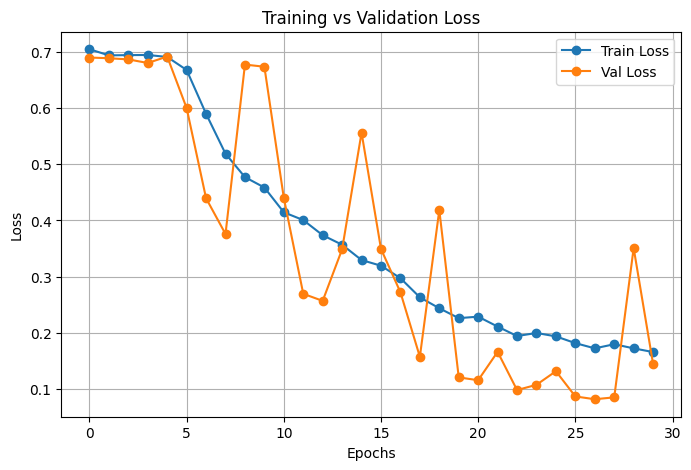

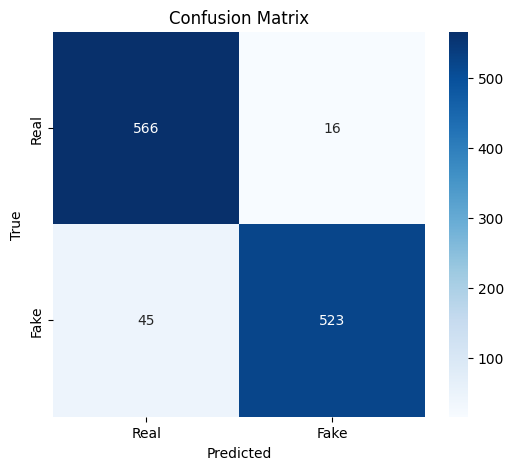

In [ ]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]
        self.transform = transform

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)

            if self.transform:
                mel_spec = self.transform(mel_spec)

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Data Augmentation: Random rotation and flip
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)  # Rotate randomly within 10 degrees
])

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load datasets with augmentation for the training set
train_dataset = AudioDataset("FoR reduced dataset/training", transform=train_transform)
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Simpler CRNN Model
class SimpleCRNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Dropout(0.5)  # Added Dropout for regularization
        )

        self.lstm = nn.LSTM(input_size=128*32, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        x = self.conv(x)  # (batch, 128, 16, 32)
        x = x.permute(0, 2, 3, 1)  # (batch, time=16, width=32, channels=128)
        x = x.reshape(x.size(0), x.size(1), -1)  # (batch, time=16, features=128*32)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use last time step
        return x

# Initialize model, loss, optimizer, scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early Stopping & Saving Best Model
best_val_loss = float("inf")
patience_counter = 0
best_epoch = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}, best epoch: {best_epoch+1}")
            break

    scheduler.step(val_loss)

# Load the best model
model.load_state_dict(torch.load("crnn_reduced_hypertuned.pth"))

# Performance Metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### ResNet18

Epoch 1/30 [Validation]: 100%|██████████| 36/36 [00:26<00:00,  1.37it/s, loss=0.289]  


Epoch 1/30 - Train Loss: 0.2476, Train Acc: 89.08%, Val Loss: 0.1644, Val Acc: 93.13%


Epoch 2/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.44it/s, loss=0.0713]  


Epoch 2/30 - Train Loss: 0.0606, Train Acc: 98.04%, Val Loss: 0.0551, Val Acc: 98.61%


Epoch 3/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s, loss=0.00228] 


Epoch 3/30 - Train Loss: 0.0420, Train Acc: 98.57%, Val Loss: 0.0766, Val Acc: 98.26%


Epoch 4/30 [Validation]: 100%|██████████| 36/36 [00:25<00:00,  1.42it/s, loss=0.148]   


Epoch 4/30 - Train Loss: 0.0274, Train Acc: 99.19%, Val Loss: 0.0846, Val Acc: 97.39%


Epoch 5/30 [Validation]: 100%|██████████| 36/36 [00:25<00:00,  1.39it/s, loss=0.183]   


Epoch 5/30 - Train Loss: 0.0255, Train Acc: 99.12%, Val Loss: 0.1118, Val Acc: 96.09%


Epoch 6/30 [Validation]: 100%|██████████| 36/36 [00:25<00:00,  1.40it/s, loss=0.0021]  


Epoch 6/30 - Train Loss: 0.0088, Train Acc: 99.81%, Val Loss: 0.0312, Val Acc: 99.30%


Epoch 7/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.00192] 


Epoch 7/30 - Train Loss: 0.0056, Train Acc: 99.86%, Val Loss: 0.0280, Val Acc: 99.57%


Epoch 8/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s, loss=0.00517] 


Epoch 8/30 - Train Loss: 0.0105, Train Acc: 99.67%, Val Loss: 0.0307, Val Acc: 99.04%


Epoch 9/30 [Validation]: 100%|██████████| 36/36 [00:25<00:00,  1.44it/s, loss=0.0012]  


Epoch 9/30 - Train Loss: 0.0137, Train Acc: 99.52%, Val Loss: 0.0911, Val Acc: 97.30%


Epoch 10/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.213]   


Epoch 10/30 - Train Loss: 0.0210, Train Acc: 99.24%, Val Loss: 0.1113, Val Acc: 96.43%


Epoch 11/30 [Validation]: 100%|██████████| 36/36 [00:25<00:00,  1.44it/s, loss=0.00658] 


Epoch 11/30 - Train Loss: 0.0170, Train Acc: 99.40%, Val Loss: 0.0308, Val Acc: 99.48%


Epoch 12/30 [Validation]: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s, loss=0.00397] 

Epoch 12/30 - Train Loss: 0.0026, Train Acc: 99.93%, Val Loss: 0.0380, Val Acc: 99.48%
Early stopping triggered.

=== Performance Metrics ===
Precision: 0.9948
Recall:    0.9948
F1 Score:  0.9948


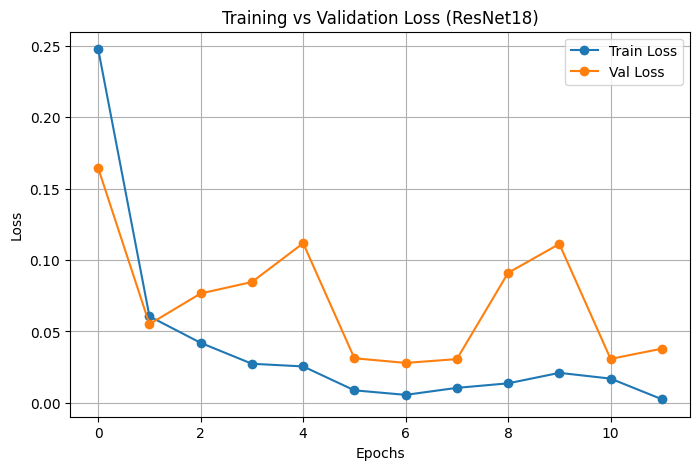

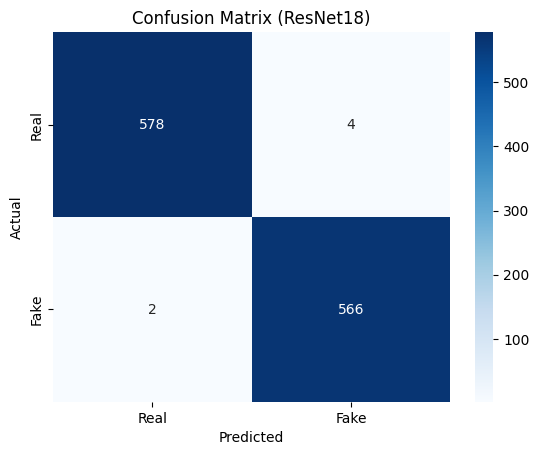

In [4]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]

            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # (3, 128, 256)

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Modified ResNet18
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Init model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "resnet18_best_reduced.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (ResNet18)")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ResNet18)")
plt.show()


### ResNet50

/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.102]   


Epoch 1/30 - Train Loss: 0.1886, Train Acc: 92.52%, Val Loss: 0.1063, Val Acc: 96.70%


Epoch 2/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.301]   


Epoch 2/30 - Train Loss: 0.0521, Train Acc: 98.33%, Val Loss: 0.2483, Val Acc: 93.04%


Epoch 3/30 [Validation]: 100%|██████████| 36/36 [01:09<00:00,  1.93s/it, loss=0.00521]


Epoch 3/30 - Train Loss: 0.0317, Train Acc: 98.90%, Val Loss: 0.0902, Val Acc: 96.87%


Epoch 4/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.00458] 


Epoch 4/30 - Train Loss: 0.0241, Train Acc: 99.24%, Val Loss: 0.0320, Val Acc: 99.04%


Epoch 5/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.87s/it, loss=0.000948]


Epoch 5/30 - Train Loss: 0.0095, Train Acc: 99.76%, Val Loss: 0.0233, Val Acc: 99.39%


Epoch 6/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.89s/it, loss=0.183]   


Epoch 6/30 - Train Loss: 0.0282, Train Acc: 98.95%, Val Loss: 0.1194, Val Acc: 96.35%


Epoch 7/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.0905]  


Epoch 7/30 - Train Loss: 0.0327, Train Acc: 98.88%, Val Loss: 0.1499, Val Acc: 95.13%


Epoch 8/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.00392] 


Epoch 8/30 - Train Loss: 0.0189, Train Acc: 99.31%, Val Loss: 0.0283, Val Acc: 99.39%


Epoch 9/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.00857] 


Epoch 9/30 - Train Loss: 0.0039, Train Acc: 99.95%, Val Loss: 0.0366, Val Acc: 99.22%


Epoch 10/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=0.000187]


Epoch 10/30 - Train Loss: 0.0016, Train Acc: 99.95%, Val Loss: 0.0206, Val Acc: 99.48%


Epoch 11/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.88s/it, loss=5.94e-5] 


Epoch 11/30 - Train Loss: 0.0033, Train Acc: 99.93%, Val Loss: 0.0239, Val Acc: 99.48%


Epoch 12/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.87s/it, loss=3.15e-5] 


Epoch 12/30 - Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.0216, Val Acc: 99.39%


Epoch 13/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.89s/it, loss=4.8e-5]  


Epoch 13/30 - Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.0212, Val Acc: 99.48%


Epoch 14/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.87s/it, loss=4.35e-5] 


Epoch 14/30 - Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.0208, Val Acc: 99.48%


Epoch 15/30 [Validation]: 100%|██████████| 36/36 [01:07<00:00,  1.87s/it, loss=0.000107]

Epoch 15/30 - Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.0229, Val Acc: 99.39%
Early stopping triggered.

=== Performance Metrics ===
Precision: 0.9939
Recall:    0.9939
F1 Score:  0.9939


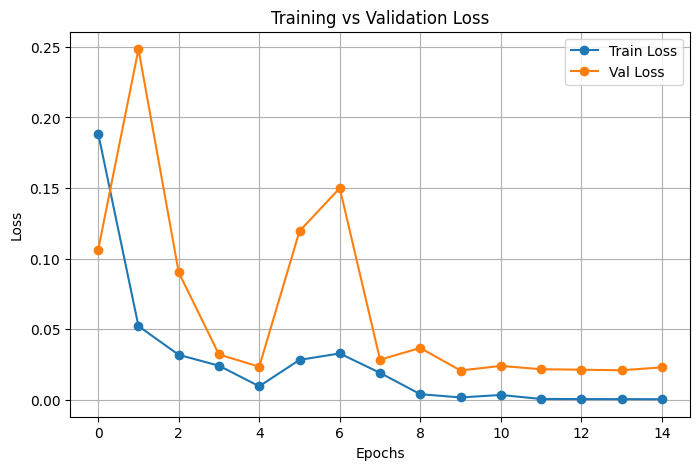

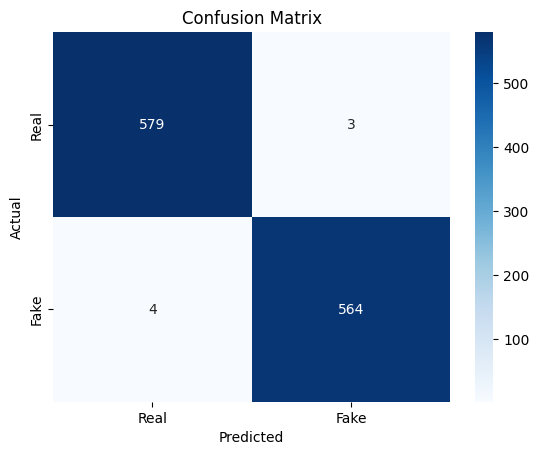

In [8]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5 

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure the spectrogram has a fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]

            # Normalize and convert to tensor
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # Convert to 3 channels for ResNet

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Load Pretrained ResNet50 and Modify
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training with Early Stopping
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")  # Progress bar
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")  # Progress bar
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save the best model
        torch.save(model.state_dict(), "resnet50_best_reduced.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Compute Precision, Recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

# Print Metrics
print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### EfficientNet-B0 

/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/kartl/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 22.5MB/s]
Epoch 1/30 [Validation]: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it, loss=0.0109] 


Epoch 1/30 - Train Loss: 0.2580, Train Acc: 89.89%, Val Loss: 0.0461, Val Acc: 98.87%


Epoch 2/30 [Validation]: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it, loss=0.00401]


Epoch 2/30 - Train Loss: 0.0425, Train Acc: 98.71%, Val Loss: 0.0103, Val Acc: 99.74%


Epoch 3/30 [Validation]: 100%|██████████| 36/36 [00:46<00:00,  1.28s/it, loss=0.000187]


Epoch 3/30 - Train Loss: 0.0222, Train Acc: 99.24%, Val Loss: 0.0827, Val Acc: 96.70%


Epoch 4/30 [Validation]: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it, loss=0.00109] 


Epoch 4/30 - Train Loss: 0.0107, Train Acc: 99.64%, Val Loss: 0.0065, Val Acc: 99.83%


Epoch 5/30 [Validation]: 100%|██████████| 36/36 [00:45<00:00,  1.28s/it, loss=0.000456]


Epoch 5/30 - Train Loss: 0.0086, Train Acc: 99.69%, Val Loss: 0.0163, Val Acc: 99.39%


Epoch 6/30 [Validation]: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it, loss=0.000115]


Epoch 6/30 - Train Loss: 0.0088, Train Acc: 99.78%, Val Loss: 0.0038, Val Acc: 99.83%


Epoch 7/30 [Validation]: 100%|██████████| 36/36 [00:48<00:00,  1.35s/it, loss=0.000156]


Epoch 7/30 - Train Loss: 0.0091, Train Acc: 99.69%, Val Loss: 0.0064, Val Acc: 99.83%


Epoch 8/30 [Validation]: 100%|██████████| 36/36 [00:54<00:00,  1.52s/it, loss=0.00188]


Epoch 8/30 - Train Loss: 0.0043, Train Acc: 99.88%, Val Loss: 0.0048, Val Acc: 100.00%


Epoch 9/30 [Validation]: 100%|██████████| 36/36 [00:45<00:00,  1.27s/it, loss=0.000742]


Epoch 9/30 - Train Loss: 0.0077, Train Acc: 99.83%, Val Loss: 0.0042, Val Acc: 99.91%


Epoch 10/30 [Validation]: 100%|██████████| 36/36 [00:57<00:00,  1.61s/it, loss=3.97e-5] 


Epoch 10/30 - Train Loss: 0.0025, Train Acc: 99.95%, Val Loss: 0.0058, Val Acc: 99.74%


Epoch 11/30 [Validation]: 100%|██████████| 36/36 [01:03<00:00,  1.75s/it, loss=8.88e-5] 

Epoch 11/30 - Train Loss: 0.0032, Train Acc: 99.90%, Val Loss: 0.0039, Val Acc: 99.83%
Early stopping triggered.

=== Performance Metrics ===
Precision: 0.9983
Recall:    0.9983
F1 Score:  0.9983


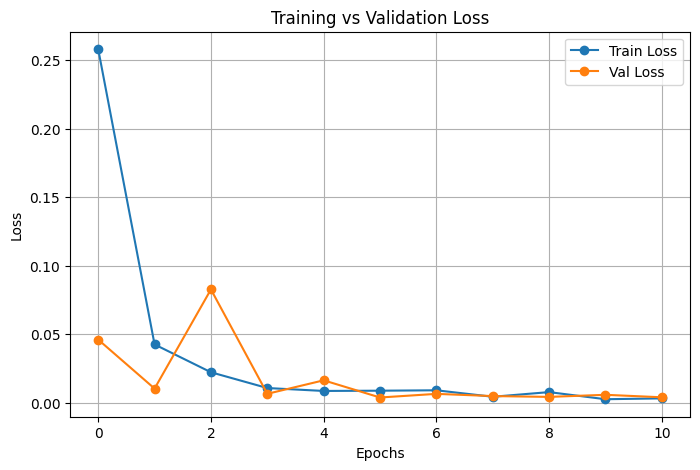

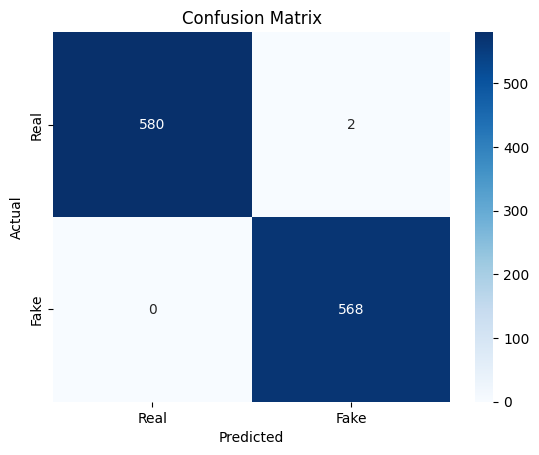

In [5]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]
            mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())  # Normalize 0-1
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # Convert to 3 channels
            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Datasets and Loaders
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# EfficientNet Model
class EfficientNetAudio(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetAudio, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetAudio().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training Loop
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)
        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")

    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "efficientnet_b0_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### MobileNetV3-Large

/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /Users/kartl/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:05<00:00, 4.27MB/s]
Epoch 1/50 [Validation]: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it, loss=0.00725]


Epoch 1/50 - Train Loss: 0.2979, Train Acc: 87.65%, Val Loss: 1.2660, Val Acc: 52.61%


Epoch 2/50 [Validation]: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s, loss=0.000125]


Epoch 2/50 - Train Loss: 0.0477, Train Acc: 98.11%, Val Loss: 0.3929, Val Acc: 81.65%


Epoch 3/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s, loss=0.00392] 


Epoch 3/50 - Train Loss: 0.0177, Train Acc: 99.50%, Val Loss: 0.0193, Val Acc: 99.48%


Epoch 4/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s, loss=6.94e-5] 


Epoch 4/50 - Train Loss: 0.0099, Train Acc: 99.67%, Val Loss: 0.0886, Val Acc: 97.30%


Epoch 5/50 [Validation]: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s, loss=6.7e-5]  


Epoch 5/50 - Train Loss: 0.0028, Train Acc: 99.90%, Val Loss: 0.0146, Val Acc: 99.57%


Epoch 6/50 [Validation]: 100%|██████████| 36/36 [00:33<00:00,  1.08it/s, loss=0.00753] 


Epoch 6/50 - Train Loss: 0.0050, Train Acc: 99.81%, Val Loss: 0.0266, Val Acc: 99.39%


Epoch 7/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s, loss=2.63e-5] 


Epoch 7/50 - Train Loss: 0.0126, Train Acc: 99.55%, Val Loss: 0.0195, Val Acc: 99.39%


Epoch 8/50 [Validation]: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s, loss=2.45e-6] 


Epoch 8/50 - Train Loss: 0.0025, Train Acc: 99.93%, Val Loss: 0.0187, Val Acc: 99.48%


Epoch 9/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s, loss=3.26e-6] 


Epoch 9/50 - Train Loss: 0.0015, Train Acc: 99.98%, Val Loss: 0.0101, Val Acc: 99.65%


Epoch 10/50 [Validation]: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s, loss=2.77e-6] 


Epoch 10/50 - Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.0118, Val Acc: 99.74%


Epoch 11/50 [Validation]: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s, loss=3.16e-6] 


Epoch 11/50 - Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.0110, Val Acc: 99.83%


Epoch 12/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s, loss=1.03e-6] 


Epoch 12/50 - Train Loss: 0.0006, Train Acc: 100.00%, Val Loss: 0.0273, Val Acc: 99.30%


Epoch 13/50 [Validation]: 100%|██████████| 36/36 [00:35<00:00,  1.00it/s, loss=9.56e-6] 


Epoch 13/50 - Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.0154, Val Acc: 99.39%


Epoch 14/50 [Validation]: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s, loss=6.29e-6] 

Epoch 14/50 - Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.0129, Val Acc: 99.57%
Early stopping triggered.

=== Performance Metrics ===
Precision: 0.9957
Recall:    0.9957
F1 Score:  0.9957


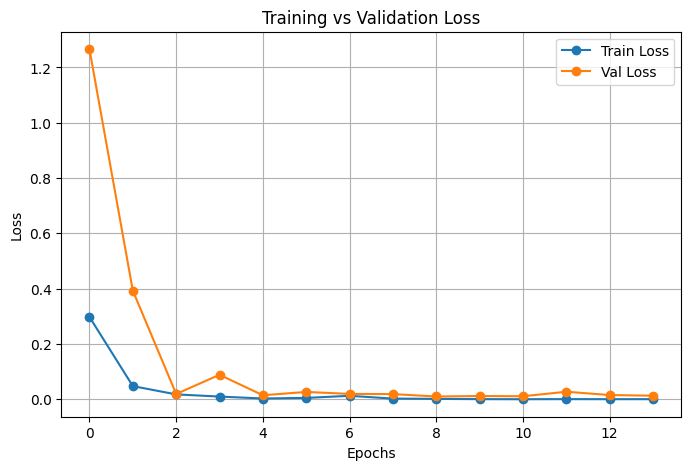

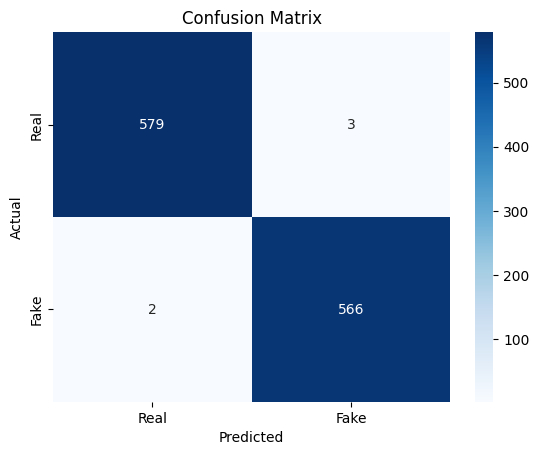

In [6]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5  # Early stopping patience

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # (3, 128, 256)

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Load Pretrained MobileNetV3 Large
class MobileNetV3LargeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3LargeClassifier, self).__init__()
        self.model = models.mobilenet_v3_large(pretrained=True)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3LargeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training with Early Stopping
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "mobilenetv3_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### ResNet101

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision import models
from tqdm import tqdm
import torchaudio

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to convert raw audio to mel-spectrogram
def audio_to_mel_spectrogram(audio_waveform):
    # Convert the raw audio to a mel-spectrogram (2D)
    mel_spec = torchaudio.transforms.MelSpectrogram()(audio_waveform)  # Output shape [1, time, freq]
    return mel_spec

# Define the model
class ResNet101Audio(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet101Audio, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Modify first convolution layer for 1-channel input (e.g., mel-spectrogram)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify final fully connected layer for binary classification (real vs fake)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 2)  # Binary classification (real vs fake)
        )

    def forward(self, x):
        return self.model(x)

# Model setup
model = ResNet101Audio().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Use Adam optimizer

# Early Stopping Variables
best_val_loss = float("inf")
patience_counter = 0
PATIENCE = 3  # Reduced patience for quicker stopping
EPOCHS = 30  # Fewer epochs
train_losses, val_losses = [], []

# Function to process batch of raw audio to mel-spectrograms
def process_batch(batch):
    mel_specs = []
    for audio in batch:
        mel_spec = audio_to_mel_spectrogram(audio)  # Convert raw audio to spectrogram
        # Ensure the spectrogram is in the correct format [batch_size, 1, time, freq]
        mel_specs.append(mel_spec.unsqueeze(0))  # Add batch dimension
    return torch.cat(mel_specs, dim=0)  # Combine into a batch

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    
    for inputs, labels in loop:
        # Process raw audio into mel-spectrograms
        inputs = process_batch(inputs)  # Convert to mel-spectrogram
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Process raw audio into mel-spectrograms
            inputs = process_batch(inputs)  # Convert to mel-spectrogram
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "ResNet101_best_reduced.pth")  # Updated save name
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Plotting loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

# Evaluate model
y_true, y_pred = [], []
model.load_state_dict(torch.load("ResNet101_best_reduced.pth"))  # Load the best saved model
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        # Process raw audio into mel-spectrograms
        inputs = process_batch(inputs)  # Convert to mel-spectrogram
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


  0%|          | 0/262 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 16, 128, 401] to have 1 channels, but got 16 channels instead

### Wave2Vec 2.0

In [4]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "facebook/wav2vec2-large-xlsr-53"
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, processor, target_length=5):
        self.processor = processor
        self.data, self.labels = [], []
        self.classes = ["real", "fake"]
        self.sr = 16000  # Sampling rate
        self.target_length = target_length * self.sr  # Fixed length in samples

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                self.data.append(os.path.join(class_path, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, _ = librosa.load(file_path, sr=self.sr)

        # 🔹 Ensure all audio inputs are of fixed length
        if len(waveform) > self.target_length:
            waveform = waveform[:self.target_length]  # Truncate
        else:
            pad_length = self.target_length - len(waveform)
            waveform = np.pad(waveform, (0, pad_length), mode="constant")  # Pad

        inputs = self.processor(waveform, sampling_rate=self.sr, return_tensors="pt", padding=True)
        return inputs.input_values.squeeze(0), torch.tensor(label, dtype=torch.long)

train_dataset = AudioDataset("FoR reduced dataset/training", processor)
val_dataset = AudioDataset("FoR reduced dataset/validation", processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)  

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Mixed Precision setup
scaler = GradScaler()

# Freeze the base model layers (except the final classification layer) to speed up training
for param in model.base_model.parameters():
    param.requires_grad = False

num_epochs = 20
train_losses, val_losses = [], []
best_val_loss = float("inf")
early_stop_patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  
    
    for batch in progress_bar:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision
        with autocast():  
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})  
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "wav2vec_best_reduced.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Final evaluation
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_98820/289502621.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20:   0%|          | 0/262 [00:00<?, ?it/s]/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_98820/289502621.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda

Epoch 1/20 | Train Loss: 0.6934 | Val Loss: 0.6932 | Acc: 0.4939 | Prec: 0.4939 | Rec: 1.0000 | F1: 0.6612


Epoch 2/20:   0%|          | 0/262 [00:00<?, ?it/s]/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_98820/289502621.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/20: 100%|██████████| 262/262 [53:21<00:00, 12.22s/it, Batch Loss=0.698]
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/20 | Train Loss: 0.6922 | Val Loss: 0.6934 | Acc: 0.5061 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000


Epoch 3/20:   0%|          | 0/262 [00:00<?, ?it/s]/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_98820/289502621.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/20: 100%|██████████| 262/262 [59:00<00:00, 13.51s/it, Batch Loss=0.704]  
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/20 | Train Loss: 0.6918 | Val Loss: 0.6933 | Acc: 0.5061 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000


Epoch 4/20:   0%|          | 0/262 [00:00<?, ?it/s]/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_98820/289502621.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/20:  15%|█▍        | 39/262 [1:02:28<5:57:16, 96.13s/it, Batch Loss=0.686]  


KeyboardInterrupt: 

### Audio Spectrogram Transformer(AST)

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Constants
SAMPLE_RATE = 16000
BATCH_SIZE = 16
EPOCHS = 20
PATIENCE = 5

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Huggingface AST feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# ✅ Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".wav"):
                    self.data.append(os.path.join(class_path, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            inputs = feature_extractor(y, sampling_rate=sr, return_tensors="pt")
            return inputs['input_values'].squeeze(0), torch.tensor(label, dtype=torch.long)
        except:
            return None

# ✅ Collate fn to skip broken samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# ✅ Dataloaders
train_dataset = AudioDataset("FoR reduced dataset/training")
val_dataset = AudioDataset("FoR reduced dataset/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ✅ AST Model
class ASTBase(nn.Module):
    def __init__(self, num_classes=2):
        super(ASTBase, self).__init__()
        self.ast = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593",
            num_labels=num_classes
        )

    def forward(self, x):
        return self.ast(x).logits

model = ASTBase().to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ✅ Early Stopping
best_val_loss = float("inf")
patience_counter = 0

# ✅ Training Loop
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # ✅ Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    # ✅ Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "ast_base_best_reduced.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("✅ Early stopping triggered!")
            break

# ✅ Load Best Model
model.load_state_dict(torch.load("ast_base_best_reduced.pth"))

# ✅ Evaluation
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# ✅ Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ✅ Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


RuntimeError: Error(s) in loading state_dict for ASTForAudioClassification:
	size mismatch for classifier.dense.weight: copying a param with shape torch.Size([527, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.dense.bias: copying a param with shape torch.Size([527]) from checkpoint, the shape in current model is torch.Size([2]).